# Chatbot V2 - Using Tensorflow & Keras

## Setup

In [5]:
import sys, os, re
import random, string, time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda

test = False
if test:
    GRU_units = 10
    batch_size = 4
    emb_dim = 10
else:
    GRU_units = 256
    batch_size = 32
    emb_dim = 50

init_lr = 0.0005

In [6]:
def progressBar(value, endvalue, bar_length=20, job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

## Reading the Data

In [7]:
lines = open('movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')

conversations = open('movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n')

# Mapping each line's id with its text
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]

# List of all Conversation's Line's ids
convs = []
for line in conversations[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort into Questions and Answers
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]], id2line[conv[i+1]]])


limit = 0
for i in range(limit, limit+10):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    print()

len(pairs)

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.


Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.


Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?


You're asking me out.  That's so cute. What's your name again?
Forget it.


No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.


Cameron.
The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.


The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.
Seems like she could get a date easy enough...


Why?
Unsolved mystery.  She used to be really popular when she st

221616

In [8]:
# replacing colloquial abbreviations and lower casing all the words

def replace_phrase(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()

    return p

replaced_pairs = replace_phrase(pairs)
replaced_pairs[:10]


[['can we make this quick  roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad  again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part  please'],
 ['not the hacking and gagging and spitting part  please',
  'okay then how about we try out some french cuisine  saturday  night'],
 ['you are asking me out  that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault  we did not have a proper introduction', 'cameron'],
 ['cameron',
  'the thing is cameron  i am at the mercy of a particularly hideous breed of loser  my sister  i cannot date until she does'],
 ['the thing is cameron  i am at the mercy of a particularly hideous breed of loser  my sister  i cannot date until she does',
  'seems like she could get a date easy enough'],
 ['why',
  'unsolved mystery  she 

In [9]:
def clean_data(pairs):
    p = pairs.copy()

    # translation table for data manupulation
    table = str.maketrans('', '', string.punctuation)

    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # remove punctuation from each token
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
         # remove tokens with numbers in them
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
         # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])

    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:10]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron'],
 ['cameron',
  'the thing is cameron i am at the mercy of a particularly hideous breed of loser my sister i cannot date until she does'],
 ['the thing is cameron i am at the mercy of a particularly hideous breed of loser my sister i cannot date until she does',
  'seems like she could get a date easy enough'],
 ['why',
  'unsolved mystery she used to be real

In [10]:
# adding starting and ending token for reference to each token

start_token = '<strartseq>'
end_token = '<endseq>'

def add_start_end_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' ' + i[0] + ' ' + end_token
        i[1] = start_token + ' ' + i[1] + ' ' + end_token
    
    return p

tokenized_pairs = add_start_end_tokens(clean_pairs)
tokenized_pairs[:10]

[['<strartseq> can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again <endseq>',
  '<strartseq> well i thought we would start with pronunciation if that is okay with you <endseq>'],
 ['<strartseq> well i thought we would start with pronunciation if that is okay with you <endseq>',
  '<strartseq> not the hacking and gagging and spitting part please <endseq>'],
 ['<strartseq> not the hacking and gagging and spitting part please <endseq>',
  '<strartseq> okay then how about we try out some french cuisine saturday night <endseq>'],
 ['<strartseq> you are asking me out that is so cute that is your name again <endseq>',
  '<strartseq> forget it <endseq>'],
 ['<strartseq> no no it is my fault we did not have a proper introduction <endseq>',
  '<strartseq> cameron <endseq>'],
 ['<strartseq> cameron <endseq>',
  '<strartseq> the thing is cameron i am at the mercy of a particularly hideous breed of loser my sister i cannot 

In [11]:
# Calculating the max length of questions and answers that
# most of the data can be placed in

def max_length(pairs, percent):
    answers = []
    questions = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])

    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    print('percentile {} of len of questions: {}'.format(percent, np.percentile(length_questions, percent)))
    print('longest question: ', max(length_questions))
    print()

    print('percentile {} of len of answers: {}'.format(percent, np.percentile(length_answers, percent)))
    print('longest answers: ', max(length_answers))
    print()

    return int(np.percentile(length_questions, percent)), int(np.percentile(length_answers, percent))
max_len_ques, max_len_ans = max_length(tokenized_pairs, 90)

print('Max Len of questions for training: ', max_len_ques)
print('Max Len of answers for training: ', max_len_ans)

percentile 90 of len of questions: 25.0
longest question:  321

percentile 90 of len of answers: 26.0
longest answers:  557

Max Len of questions for training:  25
Max Len of answers for training:  26


In [12]:
# Removing texts which are shorter than 2 words and longer than max length calculated

min_len = 2

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (len(p[0].split()) >= min_len and len(p[1].split()) >= min_len and len(p[0].split())<=max_len_ques and len(p[1].split())<=max_len_ans):
            pairs_final.append(p)

    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

180729

## Creating the vocabulary

In [13]:
# creating a vocabulary of words that occur more than a
# certain threshold

def creating_reoccuring_vocab(pairs, word_count_threshold = 5):
    p = pairs.copy()

    # creating a list of all captions
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)
 
    # only considering the words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Vocab Size: ', len(vocab))
    return vocab

short_vocab = creating_reoccuring_vocab(pairs_final, word_count_threshold=4)

# removing all one letter words except a and i
for v in short_vocab:
    if len(v) == 1 and v != 'a' and v != 'i':
        short_vocab.remove(v)

short_vocab = sorted(short_vocab)[1:]
short_vocab

Vocab Size:  18619


['<endseq>',
 '<strartseq>',
 'a',
 'aa',
 'aaaah',
 'aaaahhhh',
 'aaah',
 'aah',
 'aand',
 'aannnnaahhnn',
 'aaron',
 'ab',
 'abandon',
 'abandoned',
 'abba',
 'abbe',
 'abbott',
 'abby',
 'abc',
 'abducted',
 'abduction',
 'abe',
 'abetting',
 'abhor',
 'abide',
 'abilities',
 'ability',
 'able',
 'abnormal',
 'aboard',
 'abomination',
 'abort',
 'abortion',
 'about',
 'above',
 'abraham',
 'abrams',
 'abroad',
 'abs',
 'absence',
 'absent',
 'absenteeism',
 'absolute',
 'absolutely',
 'absorb',
 'abstract',
 'absurd',
 'absurde',
 'abuse',
 'abusive',
 'academic',
 'academy',
 'accelerate',
 'accelerated',
 'accelerating',
 'accent',
 'accents',
 'accept',
 'acceptable',
 'accepted',
 'accepting',
 'access',
 'accessed',
 'accessible',
 'accessory',
 'accident',
 'accidental',
 'accidentally',
 'accidently',
 'accidents',
 'accommodate',
 'accompanied',
 'accompany',
 'accompanying',
 'accomplices',
 'accomplish',
 'accomplished',
 'accomplishment',
 'accorded',
 'according',
 'acco

In [14]:
vocab_len = len(short_vocab) + 1
vocab_len

18595

In [15]:
def trim_rare_words(vocab, pairs):
    keep_pairs = []
    i = 0
    for pair in pairs:
        i += 1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True

        for word in input_sentence.split(' '):
            if word not in vocab:
                keep_input = False
                break

        for word in output_sentence.split(' '):
            if word not in vocab:
                keep_output = False
                break
        
        if keep_input and keep_output:
            keep_pairs.append(pair)
    
    print('\nPairs trimmed from {} pairs to {} pairs'.format(len(pairs), len(keep_pairs)))
    return keep_pairs


pairs_final = trim_rare_words(short_vocab, pairs_final)
with open('final_pairs.pkl', 'wb') as f:
    pairs_final = pickle.dump(pairs_final, f)

with open('final_pairs.pkl', 'rb') as f:
    pairs_final = pickle.load(f)

pairs_final_train = pairs_final
len(pairs_final_train)
        

Job Completion: [------------------->] 100%
Pairs trimmed from 180729 pairs to 143758 pairs


143758

In [16]:
# Tokenizing the texts
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(short_vocab)

#index to word dictionary
indextoword = {}
#word to index dictionary
wordtoindex = tokenizer.word_index
pad_token = 'pad0'

# no word in vocab has index 0. but padding is indicated with 0
indextoword[0] = pad_token

for w in tokenizer.word_index:
    indextoword[tokenizer.word_index[w]] = w

## Making the Model

In [18]:
# Making the Embedding Matrix
def make_embedding_layer(embedding_dim = 100, glove = True):
    # GloVe is an unsupervised learning algorithm for
    # obtaining vector representations for words. Training
    # is performed on aggregated global word-word
    # co-occurrence statistics from a corpus, and the
    # resulting representations showcase interesting linear
    # substructures of the word vector space.
    if glove == False:
        print('Zero Matrix Loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim))
    else:
        print('Loading glove...')
        glove_dir = './glove'
        embeddings_index = {}
        f = open('glove.6B.50d.txt', encoding='utf-8')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ", embedding_dim, 'loaded !')
        # get 200-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_len, embedding_dim))
        # to import as weights for Keras Embedding layer
        for word, i in wordtoindex.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False)
    # we have a limited vocab so we
    # do not train the embedding layer
    # we use 0 as padding so => mask_zero = true
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])

    return embedding_layer

embeddings = make_embedding_layer(embedding_dim = emb_dim, glove=not test)


Loading glove...
GloVe  50 loaded !


In [19]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units
        self.embeddings = embeddings

        self.Bidirectional1 = Bidirectional(GRU(enc_units, return_sequences=True, return_state=False, recurrent_initializer='glorot_uniform', name='gru_1'), name='bidirectional_encoder1')
        self.Bidirectional2 = Bidirectional(GRU(enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform', name='gru_2'), name='bidirectional_encoder2')

        self.dropout = Dropout(0.2)
        # imput layer size is same as that of max question length
        self.Inp = Input(shape=(max_len_ques,))

    def bidirectional(self, bidir, layer, inp, hidden):
        return bidir(layer(inp, initial_state= hidden))

    def call(self, x, hidden):
        x = self.embeddings(x)
        x = self.dropout(x)
        output, state_f, state_b = self.Bidirectional2(x)

        return output, state_f, state_b
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_len, emb_dim, GRU_units)

In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [22]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings

        #since we are using a bidirectional encoder
        self.units = 2 * dec_units
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        #used for attention
        self.attention = BahdanauAttention(self.units)
        self.decoder_gru_l1 = GRU(self.units, return_sequences=True, return_state=False, recurrent_initializer='glorot_uniform', name='decoder_gru1')
        self.decoder_gru_l2 = GRU(self.units, return_sequences=False, return_state=True, recurrent_initializer='glorot_uniform', name='decoder_gru2')
        self.dropout = Dropout(0.4)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embeddings(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        x = self.decoder_gru_l1(x)
        x = self.dropout(x)
        output, state = self.decoder_gru_l2(x)
        x = self.fc(output)
        return x, state, attention_weights

In [23]:
decoder = Decoder(vocab_len, emb_dim, GRU_units)

## Replying to Questions

In [24]:
import unicodedata
import matplotlib.ticker as ticker

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


In [25]:
def evaluate(sentence):
    attention_plot = np.zeros((max_len_ans, max_len_ques))
    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoindex[i] for i in sentence.split(' ')]
    inputs = [wordtoindex[start_token]] + inputs + [wordtoindex[end_token]]
    inputs = pad_sequences([inputs], maxlen=max_len_ques, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoindex[start_token]], 1)

    for t in range(max_len_ans):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        predicted_id = K.get_value(tf.argmax(predictions[0]))
        if indextoword[predicted_id] == end_token:
            return result, sentence, attention_plot

        result += indextoword[predicted_id] + ' '

        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

In [26]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_sublot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict = fontdict, rotation = 90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [27]:
def answer(sentence, training = False):
    result, sentence, attention_plot = evaluate(sentence)

    if training:
        return result

    print('Input: ', sentence)
    print('Predicted Answer: {}'.format(result))
    attention_plot = attention_plot[1: len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

In [28]:
def beam_search(sentence, k = 3, maxsample = max_len_ans, use_unk = False, oov = None, eos = end_token):
    """
    return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """

    dead_k = 0  #samples that reached eos
    dead_samples = []
    dead_scores = []

    live_k = 1  #samples that did not reach eos
    live_samples = [[wordtoindex[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoindex[i] for i in sentence.split(' ')]
    inputs = [wordtoindex[start_token]] + inputs + [wordtoindex[end_token]]
    inputs = pad_sequences([inputs], maxlen=max_len_ques, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden, end_hidden_b = encoder(inputs, hidden)
    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, end_hidden_b])
    dec_input = tf.expand_dims([wordtoindex[start_token]], 0)

    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_out)
        probs = K.get_value(predictions[0])

        cand_scores = np.array(live_scores)[:, None] - np.log(probs)

        if not use_unk and oov is not None:
            cand_scores[:, oov] = 1e20
        
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k - dead_k)]
        live_scores - cand_flat[ranks_flat]

         # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size] + [r%voc_size] for r in ranks_flat]

         # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]

        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]


## Defining Optimizer and Loss Function

In [29]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits=False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Training
1. Pass the *input* through the *encoder* which returns *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [30]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoindex[start_token]] * batch_size , 1)

         # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            #passing enc_output to decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)

             # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
             # expected output at this time becomes input for next timestep

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss
    

In [31]:
history = {'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 200
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size

current_ep = 1

In [38]:
def test_bot(k = 3, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'Hey what is up'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q= 'Will you be my friend'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What are you doing right now'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite movie'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite country'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'Who are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'Do you want to go out with me'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What came first eggs or chickens'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*50)

In [39]:
def plot_history():
    plt.figure(figsize=(4, 3))
    plt.plot(best_ep, smallest_loss, 'ro')
    plt.plot(history['loss'], 'b-')
    plt.legend(['best', 'loss'])
    plt.show()

Epoch: 1 Batch: 748 Loss: 1.3597
Epoch: 1 Batch: 1496 Loss: 1.5935
Epoch: 1 Batch: 2244 Loss: 1.8048
Epoch: 1 Batch: 2992 Loss: 1.6749
Epoch: 1 Batch: 3740 Loss: 1.5479
Epoch: 1 Batch: 4488 Loss: 1.4950
Epoch: 1 Batch: 4493 Loss: 1.4597
####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: Hey what is up ?  A: i am not you 
%
Greedy| Q: How are you doing ?  A: i am not you 
%
Greedy| Q: Will you be my friend ?  A: i am not you 
%
Greedy| Q: What are you doing right now ?  A: i am not you 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not you 
%
Greedy| Q: What is your favorite movie ?  A: i am not you 
%
Greedy| Q: What is your favorite country ?  A: i am not you 
%
Greedy| Q: Who are you ?  A: i am not you 
%
Greedy| Q: Do you want to go out with me ?  A: i am not you 
%
Greedy| Q: What came first eggs or chickens ?  A: i am not you to do 
##################################################
Checkpoint Saved!
Best epoch so far:  1  smallest loss: 1.4597328845030053


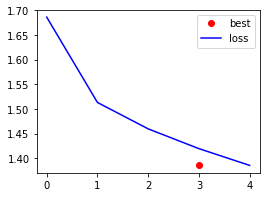

Best epoch so far:  3  smallest loss: 1.3856126168744434
Time taken for the epoch 691.3063 sec

Epoch: 4 Batch: 748 Loss: 1.2022
Epoch: 4 Batch: 1496 Loss: 1.6150
Epoch: 4 Batch: 2244 Loss: 1.6747
Epoch: 4 Batch: 2992 Loss: 1.6394
Epoch: 4 Batch: 3740 Loss: 1.4563
Epoch: 4 Batch: 4488 Loss: 1.3583
Epoch: 4 Batch: 4493 Loss: 1.3557
####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: Hey what is up ?  A: i am not you 
%
Greedy| Q: How are you doing ?  A: i am not you 
%
Greedy| Q: Will you be my friend ?  A: i am not you 
%
Greedy| Q: What are you doing right now ?  A: i am not going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not you 
%
Greedy| Q: What is your favorite movie ?  A: i am not you 
%
Greedy| Q: What is your favorite country ?  A: i am not going to be a good time 
%
Greedy| Q: Who are you ?  A: i am not you 
%
Greedy| Q: Do you want to go out with me ?  A: i am not going to do 
%
Greedy| Q: What came first eggs or chickens ?  A: i 

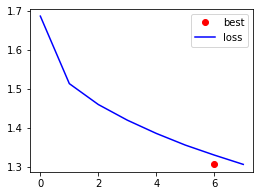

Best epoch so far:  6  smallest loss: 1.3061707140819792
Time taken for the epoch 689.8050 sec

Epoch: 7 Batch: 748 Loss: 1.2834
Epoch: 7 Batch: 1496 Loss: 1.5884
Epoch: 7 Batch: 2244 Loss: 1.6224
Epoch: 7 Batch: 2992 Loss: 1.3789
Epoch: 7 Batch: 3740 Loss: 1.3127
Epoch: 7 Batch: 4488 Loss: 1.4602
Epoch: 7 Batch: 4494 Loss: 1.2841
####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: Hey what is up ?  A: i am not you 
%
Greedy| Q: How are you doing ?  A: i am not sure you are a good time 
%
Greedy| Q: Will you be my friend ?  A: i am not you 
%
Greedy| Q: What are you doing right now ?  A: i am not sure you are a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure you are a good time 
%
Greedy| Q: What is your favorite movie ?  A: i am not sure you are a good time 
%
Greedy| Q: What is your favorite country ?  A: i am not sure you are a good time 
%
Greedy| Q: Who are you ?  A: i am not sure you are a good time 
%
Greedy| Q: Do you want to go out with

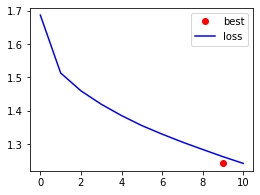

Best epoch so far:  9  smallest loss: 1.2424221837085374
Time taken for the epoch 689.4165 sec

Epoch: 10 Batch: 748 Loss: 1.1966
Epoch: 10 Batch: 1496 Loss: 1.6060
Epoch: 10 Batch: 2244 Loss: 1.4737
Epoch: 10 Batch: 2992 Loss: 1.5292
Epoch: 10 Batch: 3740 Loss: 1.1201
Epoch: 10 Batch: 4488 Loss: 1.2672
Epoch: 10 Batch: 4494 Loss: 1.2235
####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: Hey what is up ?  A: what 
%
Greedy| Q: How are you doing ?  A: i am not sure you are not sure 
%
Greedy| Q: Will you be my friend ?  A: i am not sure you are a good time 
%
Greedy| Q: What are you doing right now ?  A: i am not sure you are not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure it is a good time 
%
Greedy| Q: What is your favorite movie ?  A: oh 
%
Greedy| Q: What is your favorite country ?  A: i am not sure it is a good time 
%
Greedy| Q: Who are you ?  A: i am not sure you are a good time 
%
Greedy| Q: Do you want to go out with me ?  A: i am not su

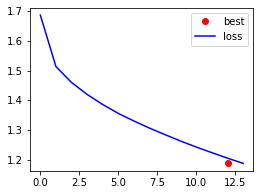

Best epoch so far:  12  smallest loss: 1.1876367448380454
Time taken for the epoch 692.0993 sec

Epoch: 13 Batch: 748 Loss: 1.0412
Epoch: 13 Batch: 1496 Loss: 1.1334
Epoch: 13 Batch: 2244 Loss: 1.5348
Epoch: 13 Batch: 2992 Loss: 1.3789
Epoch: 13 Batch: 3740 Loss: 1.1246
Epoch: 13 Batch: 4488 Loss: 1.0664
Epoch: 13 Batch: 4493 Loss: 1.1705
####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: Hey what is up ?  A: i am not sure you are not going to do 
%
Greedy| Q: How are you doing ?  A: i am not sure you are not sure you are not sure you are not sure you are not sure you are not sure you are 
%
Greedy| Q: Will you be my friend ?  A: i am not sure you are not sure you are not sure you are not sure you are not sure you are not sure you are 
%
Greedy| Q: What are you doing right now ?  A: i am not sure you are a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: oh 
%
Greedy| Q: What is your favorite movie ?  A: oh 
%
Greedy| Q: What is your favorite country ?  A: i 

KeyboardInterrupt: ignored

In [40]:
batch_loss = K.constant(0)
X, y = [], []

for ep in range(current_ep, EPOCHS):
    current_ep = ep
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:

        question = p[0]
        label = p[1]

        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoindex[word] for word in question.split(' ') if word in wordtoindex]
        label_seq = [wordtoindex[word] for word in label.split(' ') if word in wordtoindex]

        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_ques, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_ans, padding='post')[0]

        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size:
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X, y = [], []
            btch +=1

            if btch % (steps_per_epoch//6) == 0:
                print('Epoch: {} Batch: {} Loss: {:.4f}'.format(ep, btch, K.get_value(batch_loss)))

    epoch_loss = K.get_value(total_loss) / steps_per_epoch
    print('Epoch: {} Batch: {} Loss: {:.4f}'.format(ep, btch, K.get_value(epoch_loss)))

    history['loss'].append(epoch_loss)
    
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep
        print('Checkpoint Saved!')

    if  ep % 3 == 0:
        plot_history()

    print('Best epoch so far: ',best_ep,' smallest loss:',smallest_loss)
    print('Time taken for the epoch {:.4f} sec\n'.format(time.time() - start))

    print('=' * 40)   